#**CNN Model Training using Transfer Learning**


* Transfer learning is a method where knowledge gathered from one problem are used to solve similar or new problem.
* Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

**A. How to perform transfer learning?**
1. Take layers from a previously trained model.
2. Freeze all/some initial layers of the model.
3. Add some new layers in the model.
4. Train the new layers on new dataset.

**B. How to perform fine-tuning?**
1. Unfreezing the entire model 
2. Re-training it on the new data

**Mount the Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Move to the folder where dataset is uploaded in Google drive**

In [ ]:
%cd /content/drive/My\ Drive/DL4CV_18082020

/content/drive/My Drive/DL4CV_18082020


**List the files and folders present in the Google drive folder**

In [ ]:
!ls

 best_weights.hdf5	   rock.png
 cnn_classification.h5	   RPS_CNN.ipynb
 cnn_classification.hdf5   rps-cv-images
 output			   rps-cv-images.zip
 paper2.png		   scissors2.png
 paper.png		   scissors.png
'Resnet (1).ipynb'	   transfer_learning_Inceptionv3.ipynb
 results.csv		   Untitled0.ipynb
 rock2.png


**Import necessary packages**

In [ ]:
import os
import numpy as np
import keras

**Data Preprocessing**

Keras provides the ImageDataGenerator class for data preprocessing and data augmentation.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   horizontal_flip=False, vertical_flip=False, 
                                   rotation_range=15,
                                   shear_range=15,
                                   zoom_range=0.15)
test_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        'output/train',
        target_size=(299, 299),
        batch_size=64,
        class_mode='categorical'
        )
 
validation_generator = validation_datagen.flow_from_directory(
        'output/val',
        target_size=(299, 299),
        batch_size=64,
        class_mode='categorical',
        shuffle=False)
test_generator = test_datagen.flow_from_directory(
        'output/test',
        target_size=(299, 299),
        batch_size=64,
        class_mode='categorical',
        shuffle=False)

Found 1745 images belonging to 3 classes.
Found 217 images belonging to 3 classes.
Found 220 images belonging to 3 classes.


**A. Implementation of tranfer learning using keras:**

1. Instantiate a base model and load pre-trained weights into it.
2. Freeze all layers in the base model by setting trainable = False.
3. Create a new model on top of the output of one (or several) layers from the base model.
4. Train new model on new dataset.


**A.1 Loading the Inceptionv3 model with ImageNet pre-trained weights**

In [ ]:
base_model =keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299, 299,3)
)
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

**A.2 Freeze all the layers of Inceptionv3**

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

**A.3 Adding new layers to Inception model**


In [ ]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
model = models.Sequential()
# Add the Inception convolutional base model
model.add(base_model)

# Add new layers
model.add(layers.GlobalAveragePooling2D())

model.add(layers.Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 2048)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 6,147
Non-trainable params: 21,802,784
_________________________________________________________________


**A.4 Model Compilation**

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

**A.5 Model Training**

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath='inception_best_weights.hdf5'
checkpointer=ModelCheckpoint(filepath,monitor='val_acc',mode='max',save_best_only=True,verbose=1)
epochs = 10
history=model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        callbacks=[checkpointer],
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        verbose=1)

Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 0.7657 - acc: 0.6758 
Epoch 00001: val_acc improved from -inf to 0.90104, saving model to inception_best_weights.hdf5
27/27 [==============================] - 604s 22s/step - loss: 0.7657 - acc: 0.6758 - val_loss: 0.4322 - val_acc: 0.9010
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 0.2719 - acc: 0.9518
Epoch 00002: val_acc improved from 0.90104 to 0.97396, saving model to inception_best_weights.hdf5
27/27 [==============================] - 36s 1s/step - loss: 0.2719 - acc: 0.9518 - val_loss: 0.2026 - val_acc: 0.9740
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 0.1821 - acc: 0.9584
Epoch 00003: val_acc improved from 0.97396 to 0.98438, saving model to inception_best_weights.hdf5
27/27 [==============================] - 36s 1s/step - loss: 0.1821 - acc: 0.9584 - val_loss: 0.1518 - val_acc: 0.9844
Epoch 4/10
27/27 [==============================] - ETA: 0s - loss: 0.1389 - ac

**A.6 Testing the performance of the model**

In [ ]:
test_output= model.evaluate_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
print(test_output)
print(model.metrics_names)

Instructions for updating:
Please use Model.evaluate, which supports generators.
4/3 [==================================] - 62s 16s/step - loss: 0.0576 - acc: 0.9955
[0.05760234594345093, 0.9954545497894287]
['loss', 'acc']


**A.7 Plotting the training accuracy and loss graph**

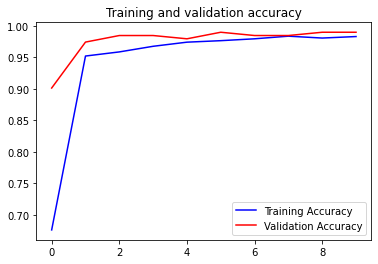

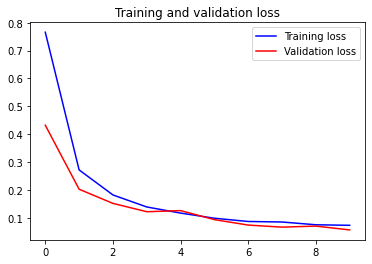

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

###**Fine-tuning**

**B.1 Loading the Inception V3 model with ImageNet pre-trained weights**

In [ ]:
new_base_model =keras.applications.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(299, 299,3)
)
new_base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_188 (Conv2D)             (None, 149, 149, 32) 864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_188 (BatchN (None, 149, 149, 32) 96          conv2d_188[0][0]                 
__________________________________________________________________________________________________
activation_188 (Activation)     (None, 149, 149, 32) 0           batch_normalization_188[0][0]    
_______________________________________________________________________________________

**B.2 Adding new layers to Inceptionv3 model**


In [ ]:
from keras import models
from keras import layers
from keras import optimizers
 
# Create the model
new_model = models.Sequential()
# Add the Inception v3 convolutional base model
new_model.add(new_base_model)

# Add new layers
new_model.add(layers.GlobalAveragePooling2D())

new_model.add(layers.Dense(3, activation='softmax'))
 
# Show a summary of the model. Check the number of trainable parameters
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 6147      
Total params: 21,808,931
Trainable params: 21,774,499
Non-trainable params: 34,432
_________________________________________________________________


**B.3 Model Compilation**

In [ ]:
new_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

**B.4 Model Training**

In [ ]:
from keras.callbacks import ModelCheckpoint
filepath='inception_finetuning_best_weights.hdf5'
checkpointer=ModelCheckpoint(filepath,monitor='val_acc',mode='max',save_best_only=True,verbose=1)
epochs = 10
new_history=new_model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=epochs,
        callbacks=[checkpointer],
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size,
        verbose=1)

Epoch 1/10
27/27 [==============================] - ETA: 0s - loss: 0.1469 - acc: 0.9381
Epoch 00001: val_acc improved from -inf to 0.75521, saving model to inception_finetuning_best_weights.hdf5
27/27 [==============================] - 43s 2s/step - loss: 0.1469 - acc: 0.9381 - val_loss: 3.0586 - val_acc: 0.7552
Epoch 2/10
27/27 [==============================] - ETA: 0s - loss: 0.0303 - acc: 0.9925
Epoch 00002: val_acc improved from 0.75521 to 0.88542, saving model to inception_finetuning_best_weights.hdf5
27/27 [==============================] - 45s 2s/step - loss: 0.0303 - acc: 0.9925 - val_loss: 0.3174 - val_acc: 0.8854
Epoch 3/10
27/27 [==============================] - ETA: 0s - loss: 0.0144 - acc: 0.9946
Epoch 00003: val_acc improved from 0.88542 to 0.95833, saving model to inception_finetuning_best_weights.hdf5
27/27 [==============================] - 44s 2s/step - loss: 0.0144 - acc: 0.9946 - val_loss: 0.1467 - val_acc: 0.9583
Epoch 4/10
27/27 [==============================]

**B.5 Testing the performance of the model**

In [ ]:
test_output= new_model.evaluate_generator(test_generator, steps=test_generator.samples/test_generator.batch_size, verbose=1)
print(test_output)
print(model.metrics_names)

4/3 [==================================] - 1s 175ms/step - loss: 0.0642 - acc: 0.9864
[0.06420444697141647, 0.9863636493682861]
['loss', 'acc']


**B.6 Plotting the training accuracy and loss graph**

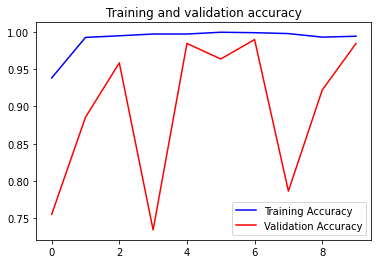

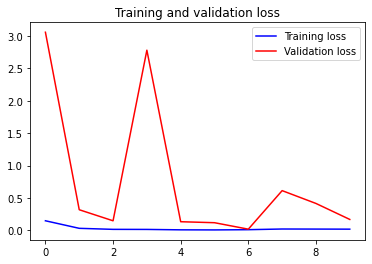

In [ ]:
import matplotlib.pyplot as plt
acc = new_history.history['acc']
val_acc = new_history.history['val_acc']
loss = new_history.history['loss']
val_loss = new_history.history['val_loss']
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

References:

1. https://keras.io/guides/transfer_learning/

2. https://pypi.org/project/split-folders/

3. https://keras.io/api/applications/